<a href="https://colab.research.google.com/github/nahyunryou/BigContest2022/blob/main/SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# user

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
user = pd.read_csv('/content/drive/MyDrive/bigcon/user_spec.csv')

In [ ]:
user= user.dropna(subset=['yearly_income','gender','birth_year'])

In [ ]:
user_category_col=['application_id','user_id','gender','income_type','employment_type','houseown_type',
                   'purpose','personal_rehabilitation_yn','personal_rehabilitation_complete_yn']
user[user_category_col]=user[user_category_col].astype('category')

user['insert_time'] = pd.to_datetime(user['insert_time'])
user['insert_month']=user['insert_time'].dt.month
user['age'] = user['birth_year'].apply(lambda x : 2022 - x +1).astype(int)

#근로형태 :EARNEDINCOME: 직장가입자(4대보험O),EARNEDINCOME2: 직장가입자(4대보험X),PRIVATEBUSINESS: 개인사업자,PRACTITIONER: 전문직,FREELANCER: 프리랜서,OTHERINCOME: 기타소득
user.income_type=user.income_type.str.lower()
#고용형태
user.employment_type=user.employment_type.cat.rename_categories(['temporary','etc','forday','fulltime'])#계약직,기타,일용직,정규직
#주거소유형태
user.houseown_type=user.houseown_type.cat.rename_categories(['otherfamily','spouse','own','monthlyrent'])#기타가족소유,배우자,자가,전월세
#대출목적
user.purpose=user.purpose.cat.rename_categories({'생활비':'living','대환대출':'switchloan','사업자금':'business','기타':'etc','전월세보증금':'housedeposit',
                                                 '주택구입':'buyhouse','투자':'invest','자동차구입':'buycar'})
user.purpose=user.purpose.str.lower()
#개인회생여부  0:개인회생자 아님, 1:개인회생자
user.personal_rehabilitation_yn = user.personal_rehabilitation_yn.cat.rename_categories(['no','yes'])
#(개인회생자인경우) 0:납입중/1:납입완료
user.personal_rehabilitation_complete_yn = user.personal_rehabilitation_complete_yn.cat.rename_categories(['no','yes'])

In [ ]:
user.application_id.cat.categories =["app_id%s" % g for g in user.application_id.cat.categories]
user.user_id.cat.categories =["user%s" % g for g in user.user_id.cat.categories]

In [ ]:
del user['birth_year']
del user['company_enter_month']
# del user['gender']

In [ ]:
fill_business = user[user['purpose']=='business']['credit_score'].mean().round(2)
fill_buycar = user[user['purpose']=='buycar']['credit_score'].mean().round(2)
fill_buyhouse = user[user['purpose']=='buyhouse']['credit_score'].mean().round(2)
fill_etc = user[user['purpose']=='etc']['credit_score'].mean().round(2)
fill_housedeposit = user[user['purpose']=='housedeposit']['credit_score'].mean().round(2)
fill_invest = user[user['purpose']=='invest']['credit_score'].mean().round(2)
fill_living = user[user['purpose']=='living']['credit_score'].mean().round(2)
fill_switchloan = user[user['purpose']=='switchloan']['credit_score'].mean().round(2)

In [ ]:
busi = user[user['purpose']=='business']['credit_score'].fillna(fill_business)
buyc = user[user['purpose']=='buycar']['credit_score'].fillna(fill_buycar)
buyh = user[user['purpose']=='buyhouse']['credit_score'].fillna(fill_buyhouse)
etc = user[user['purpose']=='etc']['credit_score'].fillna(fill_etc)
house = user[user['purpose']=='housedeposit']['credit_score'].fillna(fill_housedeposit)
inv = user[user['purpose']=='invest']['credit_score'].fillna(fill_invest)
liv = user[user['purpose']=='living']['credit_score'].fillna(fill_living)
swi = user[user['purpose']=='switchloan']['credit_score'].fillna(fill_switchloan)

In [ ]:
user['credit_score'] = pd.concat([busi,buyc,buyh,etc,house,inv,liv,swi]).sort_index()

In [ ]:
user["rehabilitation"] = "re_not"
user.loc[(user["personal_rehabilitation_yn"] == 'yes') & (user["personal_rehabilitation_complete_yn"] == 'no'),"rehabilitation"] = "re_ing" #개인회생자
user.loc[(user["personal_rehabilitation_yn"] == 'yes') & (user["personal_rehabilitation_complete_yn"] == 'yes'),"rehabilitation"] = "re_com" #개인회생 완료

In [ ]:
del user["personal_rehabilitation_yn"]
del user["personal_rehabilitation_complete_yn"]

In [ ]:
# user["existing_loan"] = "ex_non_info" #대출기록 없음
# user.loc[(-(user["existing_loan_cnt"].isna()) & (user["existing_loan_amt"].isna())),"existing_loan"] = "ex_small" #기대출1개, 소액(상환완료 가능성 높음)
# user.loc[(-(user["existing_loan_cnt"].isna()) & -(user["existing_loan_amt"].isna())),"existing_loan"] = "ex_large" #기대출1개이상, 큰금액
# user.loc[(-(user["existing_loan_cnt"].isna()) & (user["existing_loan_amt"]==0)),"existing_loan"] = "ex_com" #대출기록있음, 잔액은은0원 완납

In [ ]:
quantile_25 = np.quantile(user['yearly_income'],0.25)
quantile_75 = np.quantile(user['yearly_income'],0.75)
IQR = quantile_75 - quantile_25
minimum = quantile_25 - 1.5 * IQR
maximum = quantile_75 + 1.5 * IQR
user = user[(minimum <= user['yearly_income']) & (user['yearly_income'] <= maximum)]

In [ ]:
quantile_25 = np.quantile(user['desired_amount'],0.25)
quantile_75 = np.quantile(user['desired_amount'],0.75)
IQR = quantile_75 - quantile_25
minimum = quantile_25 - 1.5 * IQR
maximum = quantile_75 + 1.5 * IQR
user = user[(minimum <= user['desired_amount']) & (user['desired_amount'] <= maximum)]

In [ ]:
user = user[user['existing_loan_cnt']<80]

In [ ]:
# sns.boxplot(x = 'existing_loan_cnt', data=user)

In [ ]:
# user['existing_loan_cnt'].median()

In [ ]:
user['existing_loan_cnt'] = user['existing_loan_cnt'].apply(lambda x : "norm" if x < 5 else "over")

In [ ]:
user = user[user['existing_loan_amt']<2000000000]

In [ ]:
# sns.boxplot(x = 'existing_loan_amt', data=user)

In [ ]:
# user['existing_loan_amt'].mean()

In [ ]:
user['existing_loan_amt'] = user['existing_loan_amt'].apply(lambda x : "norm" if x < 62270068.19 else "over")

In [ ]:
user["existing_loan"] = "normal"
user.loc[(user['existing_loan_amt'] == 'norm') & (user['existing_loan_cnt'] == 'norm'), "existing_loan"] = "not_norm"

In [ ]:
del user["existing_loan_amt"]
del user["existing_loan_cnt"]

In [ ]:
del user['user_id']
del user['insert_time']
del user['houseown_type']
del user['insert_month']
del user['employment_type']

In [ ]:
user.columns

Index(['application_id', 'gender', 'credit_score', 'yearly_income',
       'income_type', 'desired_amount', 'purpose', 'age', 'rehabilitation',
       'existing_loan'],
      dtype='object')

In [ ]:
user = user.drop_duplicates()

In [ ]:
user

,application_id,gender,credit_score,yearly_income,income_type,desired_amount,purpose,age,rehabilitation,existing_loan
1,app_id954900,1.0,870.0,30000000.0,privatebusiness,30000000.0,switchloan,55,re_not,not_norm
2,app_id137274,1.0,710.0,30000000.0,freelancer,10000000.0,living,26,re_not,normal
3,app_id1570936,1.0,820.0,62000000.0,earnedincome,2000000.0,living,34,re_not,normal
4,app_id967833,1.0,630.0,36000000.0,earnedincome,5000000.0,living,23,re_not,not_norm
6,app_id1614045,1.0,590.0,45000000.0,otherincome,15000000.0,switchloan,47,re_not,not_norm
...,...,...,...,...,...,...,...,...,...,...
1394206,app_id304826,0.0,680.0,28000000.0,earnedincome,20000000.0,business,25,re_not,not_norm
1394207,app_id1335338,1.0,660.0,22000000.0,earnedincome,10000000.0,living,61,re_not,normal
1394208,app_id1832827,1.0,710.0,26000000.0,earnedincome,1000000.0,living,30,re_not,not_norm
1394209,app_id256365,1.0,640.0,12000000.0,earnedincome,5000000.0,switchloan,29,re_not,normal


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

col = ['yearly_income', 'desired_amount']
x = user[col].values
x_scaled = scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=col, index = user.index)
user[col] = df_temp

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder() 

cat_features = user[['income_type', 'purpose','rehabilitation','existing_loan']] # 인코딩 컬럼

cat_encoded = cat_features.apply(encoder.fit_transform) # 인코딩 실행

# 수치형 데이터로 바꿔주기

user = user.assign(income_type = cat_encoded['income_type'],purpose=cat_encoded['purpose'],
                 existing_loan=cat_encoded['existing_loan'], rehabilitation=cat_encoded['rehabilitation'])

In [ ]:
del user['application_id']

In [ ]:
user

,gender,credit_score,yearly_income,income_type,desired_amount,purpose,age,rehabilitation,existing_loan
1,1.0,870.0,0.365854,5,0.447761,7,55,2,1
2,1.0,710.0,0.365854,2,0.149254,6,26,2,0
3,1.0,820.0,0.756098,0,0.029851,6,34,2,0
4,1.0,630.0,0.439024,0,0.074627,6,23,2,1
6,1.0,590.0,0.548780,3,0.223881,7,47,2,1
...,...,...,...,...,...,...,...,...,...
1394206,0.0,680.0,0.341463,0,0.298507,0,25,2,1
1394207,1.0,660.0,0.268293,0,0.149254,6,61,2,0
1394208,1.0,710.0,0.317073,0,0.014925,6,30,2,1
1394209,1.0,640.0,0.146341,0,0.074627,7,29,2,0


https://blog.naver.com/kiakass/222511018497 rf

https://studying-haeung.tistory.com/4

In [ ]:
!pip install MiniSom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for MiniSom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=54a3eeb6ff5ea779dfb9d4ae330a50697411d053b68ce214294f2cab5b9c10c5
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built MiniSom


In [ ]:
# s_time = pd.Timestamp.now()
# print('시작시간:',s_time,'\n')

# from minisom import MiniSom  

# #원하는 파라미터 조합 리스트화
# map_n= [n for n in range(2,6)]
# para_sigma= [np.round(sigma*0.1,2) for sigma in range(1,10)]
# para_learning_rate= [np.round(learning_rate*0.1,2) for learning_rate in range(1,10)]

# #결과 값을 담을 리스트 res 생성
# res = []
# #모든 조합에 대해 모델 생성 및 qe,te값 계산
# for n in map_n:
#     for sigma in para_sigma:
#         for lr in para_learning_rate:
            
#             try:
#                 # #랜덤으로 초기값을 설정하는 경우
#                 # estimator = MiniSom(n,n,4,sigma =sigma, learning_rate = lr, topology='hexagonal',random_seed=0)
#                 # estimator.random_weights_init(user.values)
#                 # estimator.train(user.values,1000,random_order=True)
#                 # qe = estimator.quantization_error(user.values)
#                 # #te = estimator.topographic_error(user.values)
#                 # winner_coordinates = np.array([estimator.winner(x) for x in user.values]).T
#                 # cluster_index = np.ravel_multi_index(winner_coordinates,(n,n))
                
#                 # res.append([str(n)+'x'+str(n),sigma,lr,'random_init',qe,len(np.unique(cluster_index))])

#                 #pca로 초기값을 설정하는 경우
#                 estimator = MiniSom(n,n,9,sigma =sigma, learning_rate = lr,topology='hexagonal', random_seed=0)
#                 estimator.pca_weights_init(user.values)
#                 estimator.train(user.values,1000,random_order=True)
#                 qe = estimator.quantization_error(user.values)
#                 #te = estimator.topographic_error(user.values)
#                 winner_coordinates = np.array([estimator.winner(x) for x in user.values]).T
#                 cluster_index = np.ravel_multi_index(winner_coordinates,(n,n))
                
#                 res.append([str(n)+'x'+str(n),sigma,lr,'pca_init',qe,len(np.unique(cluster_index))])
                
#             except ValueError as e:
#                 print(e)

In [ ]:
# #결과 데이터프레임 생성 및 sorting 
# df_res = pd.DataFrame(res,columns=['map_size','sigma','learning_rate','init_method','qe','n_cluster']) 
# df_res.shape
# df_res.sort_values(by=['qe'],ascending=True,inplace=True,ignore_index=True)
# df_res.head(10)

$

- QE (Quantization Error) 
샘플링된 각 input vector와 BMU(Best Matching Unit)간 Euclidean 거리의 평균값을 의미하며, QE 값이 작을수록 맵이 데이터에 잘 fitting되었다고 평가된다.
output 노드의 개수가 많아질수록(맵 사이즈가 커질수록), input sample들이 맵에 더 잘 분포되어 QE값이 감소한다.   
QE 지표는 데이터 내 위상 관계(topological relations)와 무관하다. 

In [ ]:
# #시각화를 위한 lineplot 생성
# plt.figure(figsize=(20,10))
# sns.lineplot(data = df_res)

# e_time = pd.Timestamp.now()
# print('\n종료시간:',e_time,'\n총 소요시간:',e_time-s_time)

In [ ]:
# df_res[df_res.n_cluster == 4].qe.idxmin()

In [ ]:
# df_res[df_res.index==131

In [ ]:
from minisom import MiniSom  
som_b2 = MiniSom(2,2,9,sigma=0.9,learning_rate=0.1,topology='hexagonal',neighborhood_function='gaussian',activation_distance='euclidean', random_seed=0)
#초기값설정
som_b2.pca_weights_init(user.values)
som_b2.train(user.values,1000,random_order=True)

#평가
som_b2.quantization_error(user.values)
# som_b2.topographic_error(user.values)

34.93422179039304

In [ ]:
winner_coordinates = np.array([som_b2.winner(x) for x in user.values]).T
cluster_index = np.ravel_multi_index(winner_coordinates,(2,2))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from matplotlib import cm

from bokeh.plotting import figure
from bokeh.io import save, show, output_file, output_notebook
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib as mpl

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colorbar as mcbar
from matplotlib import ticker
import matplotlib.colors as mcolors
import matplotlib.colorbar as colorbar

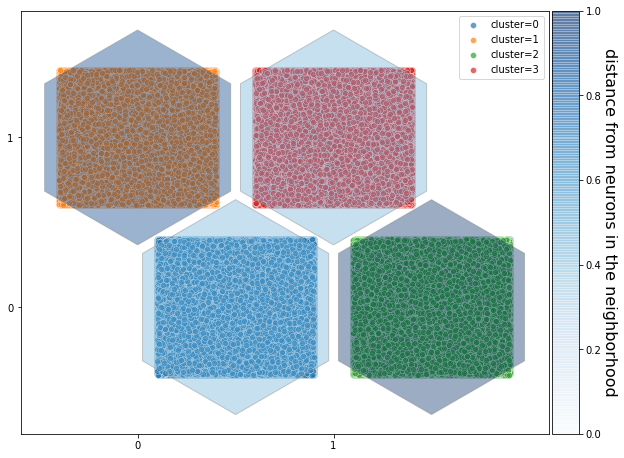

In [ ]:
xx, yy = som_b2.get_euclidean_coordinates()
umatrix = som_b2.distance_map()
weights = som_b2.get_weights()

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)
ax.set_aspect('equal')

# iteratively add hexagons
# plotting the distance map as background
# 해당 셀과 다른 이웃들 간 거리를 표현, 밝을수록 가깝고, 어두울수록 멀다
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * 2 / np.sqrt(3) * 3 / 4
        hex = RegularPolygon((xx[(i, j)], wy), 
                             numVertices=6, 
                             radius=.95 / np.sqrt(3),
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        plot = ax.add_patch(hex)

#output노드에 해당하는 클러스터 종류 및 밀도 확인         
cnt=[]
for c in np.unique(cluster_index):
        x_= [som_b2.convert_map_to_euclidean(som_b2.winner(x))[0] + (2*np.random.rand(1)[0]-1)*0.4 for x in user.values[cluster_index==c]]
        y_= [som_b2.convert_map_to_euclidean(som_b2.winner(x))[1] + (2*np.random.rand(1)[0]-1)*0.4 for x in user.values[cluster_index==c]]
        y_= [(i* 2 / np.sqrt(3) * 3 / 4) for i in y_]
    
        plot = sns.scatterplot( x = x_,  y= y_ ,label='cluster='+str(c),alpha=.7)
        
        #클러스터에 속한 데이터 개수 데이터프레임으로 출력
        cnt.append([c,len(x_)])

#클러스터별 개수를 표 형태로 출력 
df_cnt = pd.DataFrame(cnt,columns=['cluster이름','개수'])
df_cnt

#x축,y축 간격 설정 
xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plot = plt.xticks(xrange-.5, xrange)
plot = plt.yticks(yrange * 2 / np.sqrt(3) * 3 / 4, yrange)

#차트 우측에 color bar생성
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
plot = cb1.ax.set_ylabel('distance from neurons in the neighborhood',
                  rotation=270, fontsize=16)
plot = plt.gcf().add_axes(ax_cb)


In [ ]:
df_cnt = pd.DataFrame(cnt,columns=['cluster이름','개수'])
df_cnt

,cluster이름,개수
0,0,225410
1,1,145440
2,2,102554
3,3,493711


In [ ]:
cluster = pd.DataFrame({'cluster':cluster_index})

In [ ]:
final_data = user.reset_index(drop=True).join(cluster, how='left')
final_data.to_csv('/content/drive/MyDrive/bigcon/cluster.csv')

# loan

In [ ]:
# loan = pd.read_csv('/content/drive/MyDrive/빅콘/loan_result.csv')
# loan = loan.drop_duplicates()

In [ ]:
# loan['application_id']=loan['application_id'].astype('category')
# loan['product_id']=loan['product_id'].astype('category')
# loan['bank_id']=loan['bank_id'].astype('category')
# loan['is_applied']=loan['is_applied'].astype('category')

# loan.is_applied=loan.is_applied.cat.rename_categories(['fail','passed'])
# loan=loan.dropna(subset=['loan_rate'])

In [ ]:
# loan.application_id.cat.categories = ["app_id%s" % g for g in loan.application_id.cat.categories] #헷갈려서바꿈
# loan.bank_id.cat.categories =["bank%s" % g for g in loan.bank_id.cat.categories]
# loan.product_id.cat.categories =["product%s" % g for g in loan.product_id.cat.categories]

In [ ]:
# del loan['loanapply_insert_month']

# total

In [ ]:
# total = pd.merge(user, loan, on='application_id')
# total.head(5)